# NewsAPI Classification and Text Analysis
Authors: Christian Lee, Anahit Shekikyan, Graham Ward 

## Library Importing

In [ ]:
import nltk
import random
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import html

from dotenv import load_dotenv
from wordcloud import WordCloud
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

load_dotenv()

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/clee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Function Creations

Please use this section to develop functions or place them here from previous assignments

In [24]:
sw = stopwords.words("english")

punctuation = set(punctuation) # speeds up comparison

# create compiled regex obj matching one or more whitespace
ws_pattern = re.compile(r"\s+")

In [25]:
# Function creations

# Functions from previous assignments before cell
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    total_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / total_tokens if total_tokens > 0 else 0
    num_characters = sum(len(token) for token in tokens)
    
    if verbose :        
        print(f"There are {total_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        token_counts = Counter(tokens)
        print(f"The {num_tokens} most common tokens are:")
        for token, count in token_counts.most_common(num_tokens):
            print(f" {token}: {count}")
                    
    return([total_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

# construct function for cleaning and tokenizing
def clean_and_tokenize(text, stopwords):
    """
    Clean and tokenize a single speech from the conventions.

    This function applies the following steps:
      1. Converts all characters to lowercase.
      2. Removes punctuation characters by replacing them with spaces.
      3. Collapses multiple whitespace characters into a single space and strips leading/trailing spaces.
      4. Splits the cleaned string into tokens on whitespace.
      5. Removes any tokens that are in the provided stopword set.

    Parameters
    ----------
    text : str
        A single text of a speech to clean and tokenize.
    stopwords : set
        A set of stopwords (all lowercase) to filter out from the resulting tokens.

    Returns
    -------
    list of str
        A list of cleaned tokens with punctuation removed, normalized case, and stopwords excluded.
    """
    # handle coercion to string format error handling
    if text is None:
        return []
    if not isinstance(text, str):
        text = str(text)
    # make lowercase
    text = text.lower()
    # punctuation removal
    text = "".join(ch if ch not in punctuation else " " for ch in text)
    # include the removal of special characters
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    # replace whitespace with single whitespace and remove leading/trailing ws
    text = ws_pattern.sub(" ", text).strip()
    # split cleaned string on space
    tokens = text.split()
    # remove stopwords
    return [t for t in tokens if t not in stopwords]

# special character locator and counter
def find_special_characters(df, columns):
    """
    Identify all unique special characters in one or more DataFrame columns,
    and return their counts.
    
    Args:
        df (pd.DataFrame): Input dataframe
        columns (str or list): Column name(s) to search
    
    Returns:
        dict: Dictionary of special characters and their counts
    """
    if isinstance(columns, str):  # allow a single column
        columns = [columns]
        
    pattern = re.compile(r"[^a-zA-Z0-9\s]")
    counter = Counter()
    
    for col in columns:
        for text in df[col].dropna():
            matches = pattern.findall(str(text))
            counter.update(matches)
    
    return dict(counter)


## Data Importing

In [26]:
# import the articles csv into a pandas dataframe for manipulation
df = pd.read_csv('articles.csv')

# print the head of the dataframe
print(df.head())

   category                                              title  \
0  business  Hasbro leaving Pawtucket for Boston, bringing ...   
1  business  Meta suppressed children’s safety research, fo...   
2  business  PNC to buy FirstBank for $4.1B, expanding to A...   
3  business  Mortgage rates dive on reports of worsening ec...   
4  business  US Steel is shutting down a mill in Illinois. ...   

                                         description  \
0  Hasbro, the century-old company behind childho...   
1  Four whistleblowers share documents with Congr...   
2  PNC Financial plans to buy Colorado-based Firs...   
3  One housing economist says the 30-year mortgag...   
4  US Steel will stop producing steel at its Gran...   

                                             content  content_len  
0  BOSTON —Hasbro, the century-old company behind...          199  
1  Two current and two former Meta employees disc...          200  
2  NEW YORK (AP) PNC Financial said Monday that i...          

## Initial Descriptive Stats and Data Exploration

In [27]:
# print out the unique colummns of the dataframe
print(df.columns)
# print the data types of each column
print("\n", df.dtypes)

Index(['category', 'title', 'description', 'content', 'content_len'], dtype='object')

 category       object
title          object
description    object
content        object
content_len     int64
dtype: object


In [28]:
# print the number of rows in the dataframe
print("The number of rows in the dataframe are: ", df.shape[0])

The number of rows in the dataframe are:  4131


In [29]:
# get counts for each category
article_counts = df['category'].value_counts().reset_index()
# counts
article_counts.columns = ['category', 'count']
# print
print(article_counts)

        category  count
0         sports    770
1       business    714
2         health    696
3        science    669
4     technology    520
5        general    399
6  entertainment    363


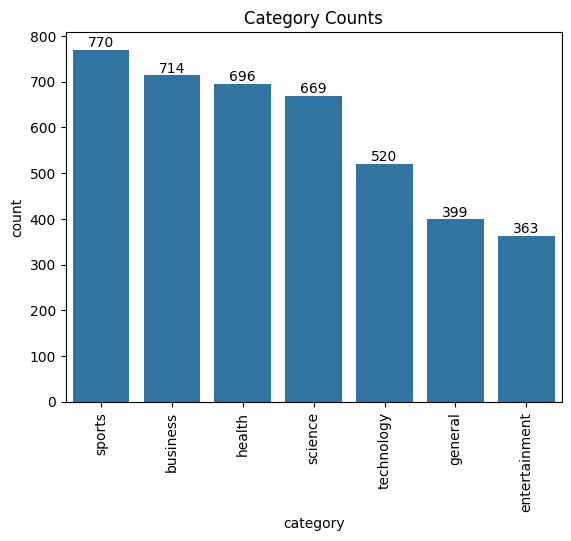

In [30]:
# visualization
ax = sns.barplot(x='category', y='count', data=article_counts)

ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.title("Category Counts")
plt.show()

In [31]:
# Find and get special character counts for contents
content_special_characters = find_special_characters(df, ["content", "description", "title"])

print(content_special_characters)

{'—': 418, ',': 11178, '-': 8015, '.': 11218, '…': 4215, '’': 2236, '(': 961, ')': 932, '$': 470, "'": 3212, '&': 234, ';': 266, ':': 1861, '<': 1446, '>': 1417, '/': 836, '?': 537, '%': 198, '"': 1119, '[': 33, ']': 34, 'é': 91, 'ç': 8, '!': 156, '¥': 1, '£': 14, '“': 355, '”': 321, 'ñ': 13, '®': 4, '@': 24, '–': 148, '{': 17, '_': 22, '}': 14, '+': 75, 'á': 16, '·': 2, 'í': 14, '*': 38, 'É': 1, '‘': 362, 'ì': 1, '#': 34, 'ô': 6, 'ö': 7, '©': 13, '|': 100, 'Ö': 1, '\xad': 3, '−': 5, '²': 2, 'À': 1, 'ó': 4, '°': 4, 'î': 1, 'ü': 4, 'ú': 5, 'Á': 3, '~': 3, 'ª': 1, 'ê': 2, '€': 2, '™': 8, '\ufeff': 5, '=': 10, '₹': 3, '\u200b': 2, '‑': 1, 'ā': 2, 'γ': 1, 'Φ': 1, '�': 6, 'ř': 1, '😎': 1, 'ʻ': 1, 'č': 1, 'ć': 2, '¿': 2, 'Ü': 2, '₮': 1, 'Í': 1, 'à': 2, 'ã': 1, '₂': 1}


In [32]:
# find and get special characters counts for description
desc_special_characters = find_special_characters(df, ["content", "description", "title"])

print(desc_special_characters)

{'—': 418, ',': 11178, '-': 8015, '.': 11218, '…': 4215, '’': 2236, '(': 961, ')': 932, '$': 470, "'": 3212, '&': 234, ';': 266, ':': 1861, '<': 1446, '>': 1417, '/': 836, '?': 537, '%': 198, '"': 1119, '[': 33, ']': 34, 'é': 91, 'ç': 8, '!': 156, '¥': 1, '£': 14, '“': 355, '”': 321, 'ñ': 13, '®': 4, '@': 24, '–': 148, '{': 17, '_': 22, '}': 14, '+': 75, 'á': 16, '·': 2, 'í': 14, '*': 38, 'É': 1, '‘': 362, 'ì': 1, '#': 34, 'ô': 6, 'ö': 7, '©': 13, '|': 100, 'Ö': 1, '\xad': 3, '−': 5, '²': 2, 'À': 1, 'ó': 4, '°': 4, 'î': 1, 'ü': 4, 'ú': 5, 'Á': 3, '~': 3, 'ª': 1, 'ê': 2, '€': 2, '™': 8, '\ufeff': 5, '=': 10, '₹': 3, '\u200b': 2, '‑': 1, 'ā': 2, 'γ': 1, 'Φ': 1, '�': 6, 'ř': 1, '😎': 1, 'ʻ': 1, 'č': 1, 'ć': 2, '¿': 2, 'Ü': 2, '₮': 1, 'Í': 1, 'à': 2, 'ã': 1, '₂': 1}


In [33]:
# Find and get special character counts for titles
title_special_characters = find_special_characters(df, ["content", "description", "title"])

print(title_special_characters)

{'—': 418, ',': 11178, '-': 8015, '.': 11218, '…': 4215, '’': 2236, '(': 961, ')': 932, '$': 470, "'": 3212, '&': 234, ';': 266, ':': 1861, '<': 1446, '>': 1417, '/': 836, '?': 537, '%': 198, '"': 1119, '[': 33, ']': 34, 'é': 91, 'ç': 8, '!': 156, '¥': 1, '£': 14, '“': 355, '”': 321, 'ñ': 13, '®': 4, '@': 24, '–': 148, '{': 17, '_': 22, '}': 14, '+': 75, 'á': 16, '·': 2, 'í': 14, '*': 38, 'É': 1, '‘': 362, 'ì': 1, '#': 34, 'ô': 6, 'ö': 7, '©': 13, '|': 100, 'Ö': 1, '\xad': 3, '−': 5, '²': 2, 'À': 1, 'ó': 4, '°': 4, 'î': 1, 'ü': 4, 'ú': 5, 'Á': 3, '~': 3, 'ª': 1, 'ê': 2, '€': 2, '™': 8, '\ufeff': 5, '=': 10, '₹': 3, '\u200b': 2, '‑': 1, 'ā': 2, 'γ': 1, 'Φ': 1, '�': 6, 'ř': 1, '😎': 1, 'ʻ': 1, 'č': 1, 'ć': 2, '¿': 2, 'Ü': 2, '₮': 1, 'Í': 1, 'à': 2, 'ã': 1, '₂': 1}


In [34]:
# identify any missing values in each column
print("Missing values for each column")
print(df.isnull().sum())

# percentage
print("\nPercentage of missing per column: ")
print((df.isnull().mean() * 100).round(2))

# number of rows missing both description and content
both_missing = df[df['description'].isnull() & df['content'].isnull()]
print(f"\nThe number of observations missing BOTH description and content is: {len(both_missing)}")

Missing values for each column
category         0
title            0
description    187
content        450
content_len      0
dtype: int64

Percentage of missing per column: 
category        0.00
title           0.00
description     4.53
content        10.89
content_len     0.00
dtype: float64

The number of observations missing BOTH description and content is: 146


## Data Cleaning and Preprocessing

In [35]:
# establish a new df_clean object for cleaning to keep original df
df_clean = df.copy()

# Establish regex patterns for removal and precleaning
# html pattern
html_tag_regex = re.compile(r"<[^>]+>")
# removal of number of characters left in content
truncate_tail_regex = re.compile(r"\[\s*\+\s*\d+\s*chars?\s*\]")
# trailing ellipses at ends 
ellipsis_end_regex = re.compile(r"(…|\.{3,})\s*$")

# text precleaning to remove 
def preclean_text(s: str) -> str:
    """
    Pre-clean raw text from the NewsAPI dataset by stripping noise and formatting artifacts.

    Steps performed:
        1. Decode HTML entities (e.g., "&amp;" → "&").
        2. Remove inline HTML tags (e.g., "<p>", "<a href=...>").
        3. Strip NewsAPI truncation markers of the form "[+123 chars]".
        4. Trim trailing ellipses at the end of text ("...", "……").
        5. Collapse multiple whitespace characters into a single space and strip edges.

    Parameters
    ----------
    s : str
        The input text string to be cleaned. Non-string or empty inputs are returned unchanged.

    Returns
    -------
    str
        A cleaned text string suitable for further cleaning.
    """
    # handles null values
    if not isinstance(s, str) or not s.strip():
        return s
    # convert html entries to normal text
    x = html.unescape(s)
    # remove HTML tags
    x = html_tag_regex.sub(" ", x)
    # remove truncation tokens
    x = truncate_tail_regex.sub(" ", x)
    # trim trailing ellipses
    x = ellipsis_end_regex.sub(" ", x)
    # collapse whitespace and reduce leading and trailing ws
    x = ws_pattern.sub(" ", x).strip()
    return x

# apply precleaning function to the text columns
for col in ['content', 'description', 'title']:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].apply(preclean_text)

In [36]:
# apply the cleaning and tokenization to each column with text data.
df_clean['title_tokens'] = df_clean['title'].apply(lambda x: clean_and_tokenize(x, sw))
df_clean['desc_tokens'] = df_clean['description'].apply(lambda x: clean_and_tokenize(x, sw))
df_clean['content_tokens'] = df_clean['content'].apply(lambda x: clean_and_tokenize(x, sw))

# get some token counts
df_clean['num_title_tokens'] = df_clean['title_tokens'].apply(len)
df_clean['num_desc_tokens'] = df_clean['desc_tokens'].apply(len)
df_clean['num_content_tokens'] = df_clean['content_tokens'].apply(len)

# view head of clean data
print(df_clean.head())

   category                                              title  \
0  business  Hasbro leaving Pawtucket for Boston, bringing ...   
1  business  Meta suppressed children’s safety research, fo...   
2  business  PNC to buy FirstBank for $4.1B, expanding to A...   
3  business  Mortgage rates dive on reports of worsening ec...   
4  business  US Steel is shutting down a mill in Illinois. ...   

                                         description  \
0  Hasbro, the century-old company behind childho...   
1  Four whistleblowers share documents with Congr...   
2  PNC Financial plans to buy Colorado-based Firs...   
3  One housing economist says the 30-year mortgag...   
4  US Steel will stop producing steel at its Gran...   

                                             content  content_len  \
0  BOSTON —Hasbro, the century-old company behind...          199   
1  Two current and two former Meta employees disc...          200   
2  NEW YORK (AP) PNC Financial said Monday that i...       

We still need to determine how we are going to handle the missing values for the description and content columns. Easiest recommendation is to just drop, we lose 10.5% of the content data, but can always rerun the older_fetch_articles python script to grab more data if needed as long as we build out this notebook.

## Exploratory Data Analysis

In [37]:
# get the new shape of the dataframe after cleaning
print(f"The new dimensions of the data are : {df_clean.shape}")

The new dimensions of the data are : (4131, 11)


In [38]:
# identify any missing values in each column
print("Missing values for each column")
print(df_clean.isnull().sum())

# percentage
print("\nPercentage of missing per column: ")
print((df_clean.isnull().mean() * 100).round(2))

# number of rows missing both description and content
both_missing = df_clean[df_clean['description'].isnull() & df_clean['content'].isnull()]
print(f"\nThe number of observations missing BOTH description and content is: {len(both_missing)}")

Missing values for each column
category                0
title                   0
description           187
content               450
content_len             0
title_tokens            0
desc_tokens             0
content_tokens          0
num_title_tokens        0
num_desc_tokens         0
num_content_tokens      0
dtype: int64

Percentage of missing per column: 
category               0.00
title                  0.00
description            4.53
content               10.89
content_len            0.00
title_tokens           0.00
desc_tokens            0.00
content_tokens         0.00
num_title_tokens       0.00
num_desc_tokens        0.00
num_content_tokens     0.00
dtype: float64

The number of observations missing BOTH description and content is: 146


## Feature Engineering

In [39]:
df_clean['comb_text'] = df_clean['title'] + ' ' + df_clean['description'] + ' ' + df_clean['content']
df_clean['comb_tokens'] = df_clean['comb_text'].apply(lambda x: clean_and_tokenize(x, sw))

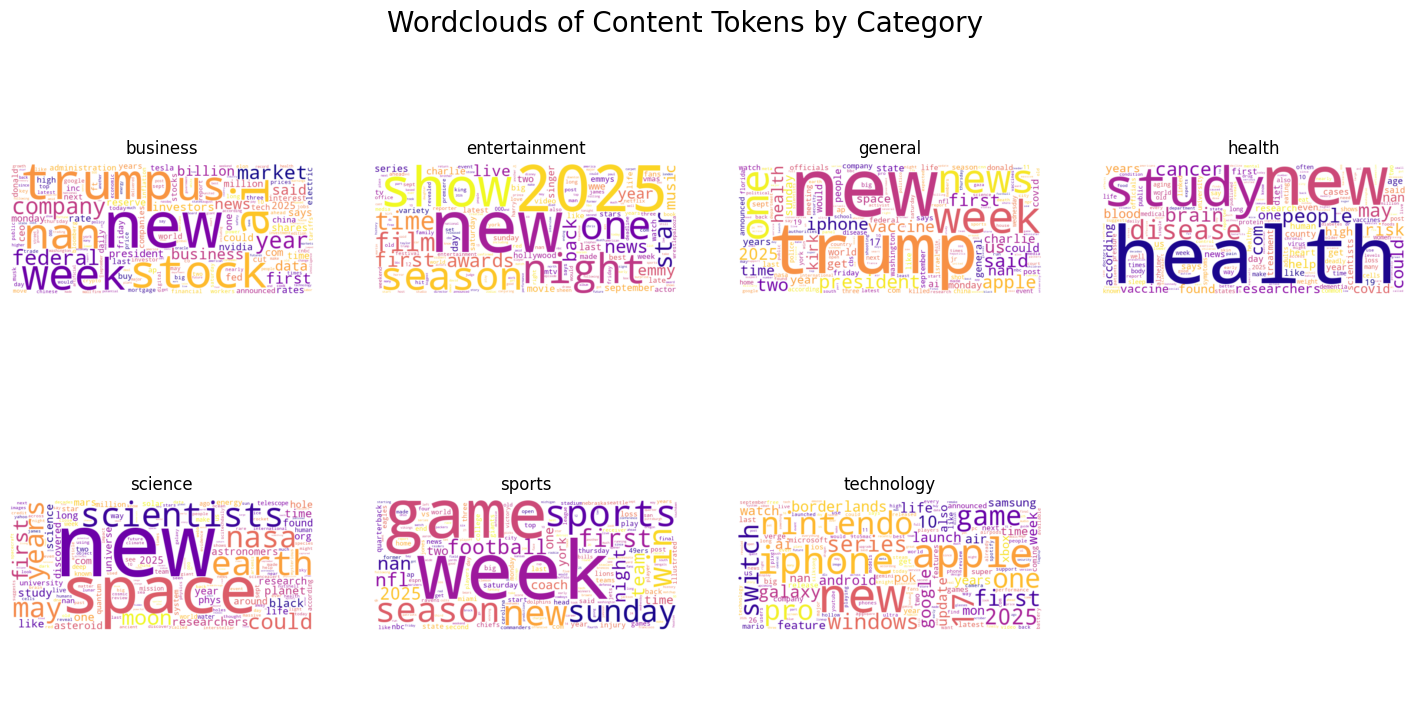

In [40]:
# Build out wordclouds for the content_tokens of each category.
# Config
MAX_WORDS = 200
MIN_TOKEN_LEN = 2
# pixel size passed to WordCloud
WIDTH, HEIGHT = 700, 300

# get categories (sorted for consistent layout)
categories = sorted(df_clean['category'].dropna().unique().tolist())

# prepare subplots: 2 rows x 4 cols
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.ravel()  # flatten to 1D index

# for loop through the list of categories
for i, cat in enumerate(categories):
    # set axis for category
    ax = axes[i]
    # aggregate tokens for content_tokens category
    tokens_series = df_clean.loc[df_clean['category'] == cat, 'comb_tokens']
    freq = Counter()
    for toks in tokens_series:
        if isinstance(toks, list):
            # light filter for readability
            freq.update([t for t in toks if isinstance(t, str) and len(t) >= MIN_TOKEN_LEN])
    # subplot formatting
    ax.set_title(str(cat), fontsize=12, pad=8)
    ax.axis("off")
    # handle the empty cases
    if len(freq) == 0:
        ax.text(0.5, 0.5, "No tokens", ha="center", va="center", fontsize=12)
        continue

    # create the wordcloud itself
    wc = WordCloud(
        width=WIDTH,
        height=HEIGHT,
        background_color="white",
        colormap="plasma",
        max_words=MAX_WORDS,
        normalize_plurals=True
    ).generate_from_frequencies(freq)

    ax.imshow(wc, interpolation="bilinear")

# hide any unused axes
for j in range(len(categories), 8):
    axes[j].axis("off")

fig.suptitle("Wordclouds of Content Tokens by Category", fontsize=20)
plt.show()

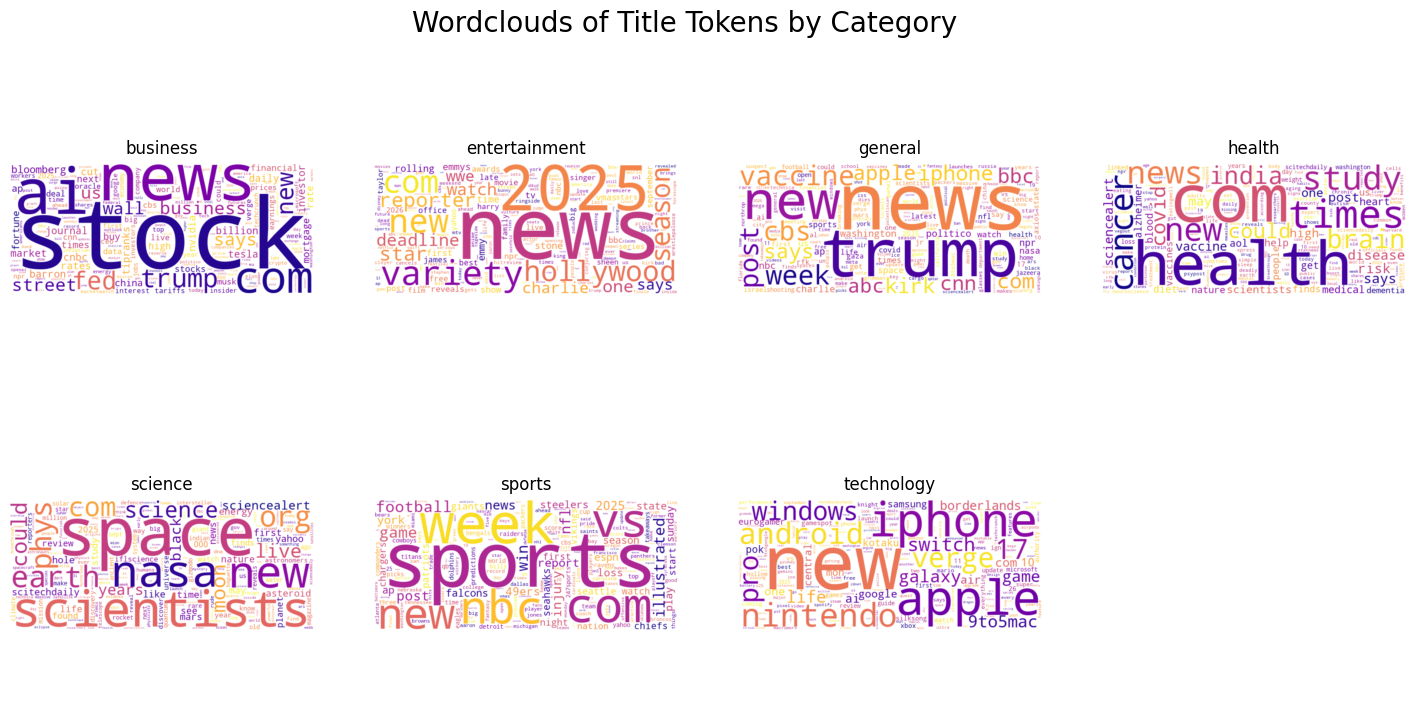

In [41]:
# Build out wordclouds for the title_tokens of each category.
# Config
MAX_WORDS = 200
MIN_TOKEN_LEN = 2
# pixel size passed to WordCloud
WIDTH, HEIGHT = 700, 300

# get categories (sorted for consistent layout)
categories = sorted(df_clean['category'].dropna().unique().tolist())

# prepare subplots: 2 rows x 4 cols
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.ravel()  # flatten to 1D index

# for loop through the list of categories
for i, cat in enumerate(categories):
    # set axis for category
    ax = axes[i]
    # aggregate tokens for content_tokens category
    tokens_series = df_clean.loc[df_clean['category'] == cat, 'title_tokens']
    freq = Counter()
    for toks in tokens_series:
        if isinstance(toks, list):
            # light filter for readability
            freq.update([t for t in toks if isinstance(t, str) and len(t) >= MIN_TOKEN_LEN])
    # subplot formatting
    ax.set_title(str(cat), fontsize=12, pad=8)
    ax.axis("off")
    # handle the empty cases
    if len(freq) == 0:
        ax.text(0.5, 0.5, "No tokens", ha="center", va="center", fontsize=12)
        continue

    # create the wordcloud itself
    wc = WordCloud(
        width=WIDTH,
        height=HEIGHT,
        background_color="white",
        colormap="plasma",
        max_words=MAX_WORDS,
        normalize_plurals=True
    ).generate_from_frequencies(freq)

    ax.imshow(wc, interpolation="bilinear")

# hide any unused axes
for j in range(len(categories), 8):
    axes[j].axis("off")

fig.suptitle("Wordclouds of Title Tokens by Category", fontsize=20)
plt.show()

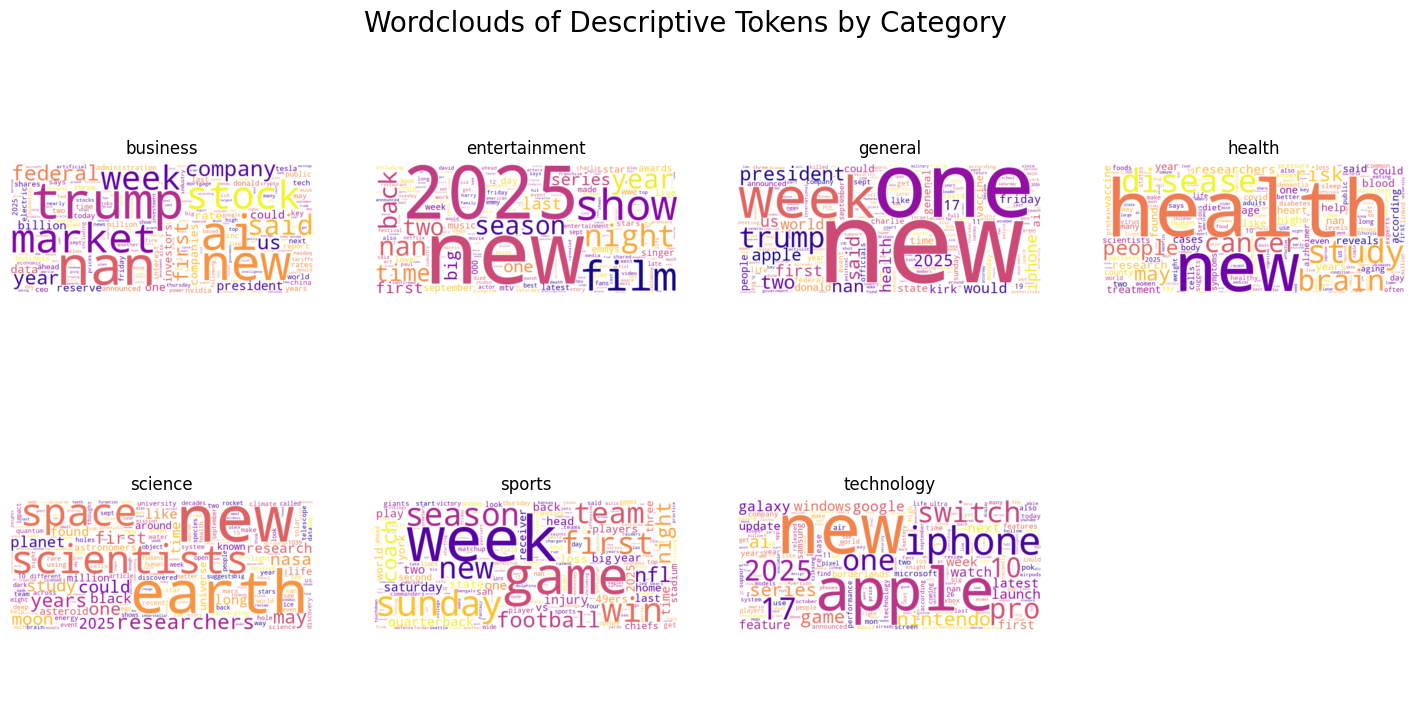

In [42]:
# Build out wordclouds for the desc_tokens of each category.
# Config
MAX_WORDS = 200
MIN_TOKEN_LEN = 2
# pixel size passed to WordCloud
WIDTH, HEIGHT = 700, 300

# get categories (sorted for consistent layout)
categories = sorted(df_clean['category'].dropna().unique().tolist())

# prepare subplots: 2 rows x 4 cols
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.ravel()  # flatten to 1D index

# for loop through the list of categories
for i, cat in enumerate(categories):
    # set axis for category
    ax = axes[i]
    # aggregate tokens for content_tokens category
    tokens_series = df_clean.loc[df_clean['category'] == cat, 'desc_tokens']
    freq = Counter()
    for toks in tokens_series:
        if isinstance(toks, list):
            # light filter for readability
            freq.update([t for t in toks if isinstance(t, str) and len(t) >= MIN_TOKEN_LEN])
    # subplot formatting
    ax.set_title(str(cat), fontsize=12, pad=8)
    ax.axis("off")
    # handle the empty cases
    if len(freq) == 0:
        ax.text(0.5, 0.5, "No tokens", ha="center", va="center", fontsize=12)
        continue

    # create the wordcloud itself
    wc = WordCloud(
        width=WIDTH,
        height=HEIGHT,
        background_color="white",
        colormap="plasma",
        max_words=MAX_WORDS,
        normalize_plurals=True
    ).generate_from_frequencies(freq)

    ax.imshow(wc, interpolation="bilinear")

# hide any unused axes
for j in range(len(categories), 8):
    axes[j].axis("off")

fig.suptitle("Wordclouds of Descriptive Tokens by Category", fontsize=20)
plt.show()

In [43]:
# use the descriptive stats for each _tokens column
# identify the columns to use
token_cols = ['title_tokens', 'desc_tokens', 'content_tokens']
# create an empty dictionary
desc_stats_summary = {}

# for loop
for col in token_cols:
    # flatten column tokens into list
    col_tokens = [t for tokens in df_clean[col] if isinstance(tokens, list) for t in tokens]
    # apply desc stats function
    stats = descriptive_stats(col_tokens, verbose=False)
    # add results to the dictionary
    desc_stats_summary[col] = {
        "Total Tokens": stats[0],
        "Unique Tokens": stats[1],
        "Lexical Diversity": round(stats[2], 3),
        "Total Characters": stats[3]
    }

# convert to df to view and transpose
desc_stats_df = pd.DataFrame(desc_stats_summary).T
display(desc_stats_df)

,Total Tokens,Unique Tokens,Lexical Diversity,Total Characters
title_tokens,43817.0,10604.0,0.242,252370.0
desc_tokens,60775.0,13995.0,0.230,368246.0
content_tokens,77426.0,16203.0,0.209,460703.0


## Data Splitting and Class Imbalance

In [44]:
from sklearn.model_selection import train_test_split

# subset only the required columns and drop rows with missing values
df_subset = df_clean[['category', 'comb_text']].dropna()

# Perform stratified split to maintain class proportions
train_df, test_df = train_test_split(
    df_subset, 
    test_size=0.2, 
    random_state=42, 
    stratify=df_subset['category']  # This ensures proportional split
)

# Verify the proportions were maintained
print("\nCategory distribution in training set:")
print(train_df['category'].value_counts(normalize=True).round(3))
print("\nCategory distribution in test set:")
print(test_df['category'].value_counts(normalize=True).round(3))

print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


Category distribution in training set:
category
sports           0.175
science          0.170
health           0.168
business         0.165
technology       0.130
general          0.099
entertainment    0.093
Name: proportion, dtype: float64

Category distribution in test set:
category
sports           0.176
science          0.169
health           0.168
business         0.165
technology       0.130
general          0.099
entertainment    0.093
Name: proportion, dtype: float64

Train shape: (2912, 2)
Test shape: (728, 2)


## Model Development (Training and Testing)

### Logistic Regression

In [49]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Create a pipeline: TF-IDF vectorizer + Logistic Regression
logreg_pipeline = make_pipeline(
    TfidfVectorizer(max_features=10000, ngram_range=(1,2)),
    LogisticRegression(max_iter=1000, random_state=42)
)

# Fit the model
logreg_pipeline.fit(train_df['comb_text'], train_df['category'])

# Predict on test set
y_pred = logreg_pipeline.predict(test_df['comb_text'])

# Calculate accuracy
accuracy = accuracy_score(test_df['category'], y_pred)

# Get evaluation report
report = classification_report(test_df['category'], y_pred, output_dict=True)

# Extract metrics
per_class_metrics = pd.DataFrame(report).T.loc[categories, ['precision', 'recall', 'f1-score']].round(4)

# Extract macro and weighted F1-scores
macro_f1 = report['macro avg']['f1-score']
weighted_f1 = report['weighted avg']['f1-score']

print("Per-class precision, recall, and F1-score:")
display(per_class_metrics)
print(f"Macro F1-score: {macro_f1:.3f}")
print(f"Weighted F1-score: {weighted_f1:.3f}")


Per-class precision, recall, and F1-score:


,precision,recall,f1-score
business,0.6458,0.7750,0.7045
entertainment,0.7736,0.6029,0.6777
general,0.5263,0.1389,0.2198
health,0.7333,0.8115,0.7704
science,0.7357,0.8374,0.7833
sports,0.7548,0.9141,0.8269
technology,0.7927,0.6842,0.7345


Macro F1-score: 0.674
Weighted F1-score: 0.704


### SVM

In [52]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

# Create a pipeline: TF-IDF vectorizer + Linear SVM
svm_pipeline = make_pipeline(
    TfidfVectorizer(max_features=10000, ngram_range=(1,2)),
    LinearSVC(max_iter=1000, random_state=42)
)

# Fit the model
svm_pipeline.fit(train_df['comb_text'], train_df['category'])

# Predict on test set
y_pred_svm = svm_pipeline.predict(test_df['comb_text'])

# Get evaluation report
report = classification_report(test_df['category'], y_pred_svm, output_dict=True)

# Extract metrics
per_class_metrics = pd.DataFrame(report).T.loc[categories, ['precision', 'recall', 'f1-score']].round(4)

# Extract macro and weighted F1-scores
macro_f1 = report['macro avg']['f1-score']
weighted_f1 = report['weighted avg']['f1-score']

print("Per-class precision, recall, and F1-score:")
display(per_class_metrics)
print(f"Macro F1-score: {macro_f1:.3f}")
print(f"Weighted F1-score: {weighted_f1:.3f}")

Per-class precision, recall, and F1-score:


,precision,recall,f1-score
business,0.6940,0.7750,0.7323
entertainment,0.7188,0.6765,0.6970
general,0.3778,0.2361,0.2906
health,0.7787,0.7787,0.7787
science,0.7482,0.8455,0.7939
sports,0.8540,0.9141,0.8830
technology,0.7701,0.7053,0.7363


Macro F1-score: 0.702
Weighted F1-score: 0.731


### Naive Bayes

In [53]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

# Create a pipeline: TF-IDF vectorizer + Multinomial Naive Bayes
nb_pipeline = make_pipeline(
    TfidfVectorizer(max_features=10000, ngram_range=(1,2)),
    MultinomialNB()
)

# Fit the model
nb_pipeline.fit(train_df['comb_text'], train_df['category'])

# Predict on test set
y_pred_nb = nb_pipeline.predict(test_df['comb_text'])

# Get evaluation report
report = classification_report(test_df['category'], y_pred_nb, output_dict=True)

# Extract metrics
per_class_metrics = pd.DataFrame(report).T.loc[categories, ['precision', 'recall', 'f1-score']].round(4)

# Extract macro and weighted F1-scores
macro_f1 = report['macro avg']['f1-score']
weighted_f1 = report['weighted avg']['f1-score']

print("Per-class precision, recall, and F1-score:")
display(per_class_metrics)
print(f"Macro F1-score: {macro_f1:.3f}")
print(f"Weighted F1-score: {weighted_f1:.3f}")

Per-class precision, recall, and F1-score:


,precision,recall,f1-score
business,0.6370,0.7750,0.6992
entertainment,0.8696,0.2941,0.4396
general,0.3333,0.0278,0.0513
health,0.6871,0.8279,0.7509
science,0.7047,0.8537,0.7721
sports,0.6816,0.9531,0.7948
technology,0.7692,0.6316,0.6936


Macro F1-score: 0.600
Weighted F1-score: 0.648


### Zero-shot classification w/ OpenAI

In [ ]:
import os

if os.path.exists("openai_batch_classification_results.json"):
    print("Results file already exists. Skipping OpenAI batch classification.")
else:
    import openai
    import json
    import time

    openai.api_key = os.getenv("OPENAI_API_KEY")

    candidate_labels = categories

    batch_inputs = []
    for idx, row in df_clean.iterrows():
        batch_inputs.append({
            "custom_id": str(idx),
            "method": "POST",
            "url": "/v1/classifications",
            "body": {
                "model": "gpt-3.5-turbo-instruct",
                "query": row["comb_text"],
                "labels": candidate_labels,
                "temperature": 0
            }
        })

    with open("openai_batch_classification_inputs.json", "w") as f:
        json.dump(batch_inputs, f, indent=2)

    batch = openai.Batch.create(
        input_file=openai.File.create(
            file=open("openai_batch_classification_inputs.json", "rb"),
            purpose="batch"
        ).id,
        endpoint="/v1/classifications",
        completion_window="24h"
    )

    print(f"Batch job created with ID: {batch.id}")
    print("You can monitor the batch job status in your OpenAI dashboard.")

    while True:
        batch_status = openai.Batch.retrieve(batch.id)
        print(f"Batch status: {batch_status.status}")
        if batch_status.status in ["completed", "failed", "cancelled"]:
            break
        time.sleep(30)

    if batch_status.status == "completed":
        result_file_id = batch_status.output_file_id
        result_file = openai.File.retrieve(result_file_id)
        result_content = openai.File.download(result_file_id)
        with open("openai_batch_classification_results.json", "wb") as f:
            f.write(result_content)
        print("Results saved to openai_batch_classification_results.json")
    else:
        print("Batch job did not complete successfully.")


In [74]:
# Load OpenAI batch classification responses
with open("openai_batch_classification_results.jsonl", "r") as f:
    responses = [json.loads(line) for line in f]

    # Extract predicted categories from OpenAI responses
    y_pred = [resp["response"]["body"]["choices"][0]["message"]["content"].strip().lower() for resp in responses]

    # Get the true labels for the same rows as the predictions
    # Assume responses are in the same order as test_df
    y_true = df_clean['category'].values

    # Print classification report
    print(classification_report(y_true, y_pred))

               precision    recall  f1-score   support

     business       0.87      0.46      0.61       714
    education       0.00      0.00      0.00         0
entertainment       0.59      0.79      0.68       363
  environment       0.00      0.00      0.00         0
      fashion       0.00      0.00      0.00         0
         food       0.00      0.00      0.00         0
      general       0.22      0.42      0.29       399
       health       0.82      0.70      0.75       696
         home       0.00      0.00      0.00         0
home & garden       0.00      0.00      0.00         0
     obituary       0.00      0.00      0.00         0
      science       0.82      0.76      0.79       669
       sports       0.83      0.79      0.81       770
   technology       0.50      0.54      0.52       520
       travel       0.00      0.00      0.00         0

     accuracy                           0.64      4131
    macro avg       0.31      0.30      0.30      4131
 weighte

/Users/clee/github/ADS509_FinalProject/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clee/github/ADS509_FinalProject/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clee/github/ADS509_FinalProject/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

## Topic Modeling

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
import numpy as np

# Vectorize the text
vectorizer = CountVectorizer(
    max_features=5000,
    stop_words='english'
)
X_train_counts = vectorizer.fit_transform(train_df['comb_text'])

# Fit LDA model
n_topics = 7  # You have 7 categories, so let's use 7 topics
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=10,
    learning_method='online',
    random_state=42
)
lda.fit(X_train_counts)

# Display top words by topic
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_features)}")

print_top_words(lda, vectorizer.get_feature_names_out())

# Assign each document to its most probable topic
topic_assignments = lda.transform(X_train_counts).argmax(axis=1)
train_df['lda_topic'] = topic_assignments

### EVALUATION

# Evaluate topic coherence with silhouette score
try:
    sil_score = silhouette_score(lda.transform(X_train_counts), topic_assignments)
    print(f"\nSilhouette Score (topic separation): {sil_score:.3f}")
except Exception as e:
    print(f"\nSilhouette Score could not be computed: {e}")

# Show topic distribution counts
topic_counts = train_df['lda_topic'].value_counts().sort_index()
print("\nDocument count per topic:")
print(topic_counts)

# For each topic, find the most common category in train_df
topic_to_category = (
    train_df.groupby('lda_topic')['category']
    .agg(lambda x: x.value_counts().idxmax())
    .rename('most_common_category')
)

# Show the mapping of topic to most common category
print(topic_to_category)

## Results